In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pickle

import math
import cv2
import numpy as np
from numpy import cos as cos
from numpy import sin as sin
from numpy import sqrt as sqrt
from numpy import arctan2 as arctan2
import os
import datetime
import time

import sys
from functions import *
from tf_functions import *
from zernike_functions import *

In [2]:
def init_param():
    ### N: pix num, p: pix size[m]
    N = 2160
    p = 3.74e-6

    ### l_ambda: wavelength
    l_ambda = 520e-9

    ### z: distance from aperture to screen
    z = 0.0254

    ### pupil_r: pupil radius, pupil_r_m: (m)
    pupil_r_m = N*p/2
    pupil_r_mm = pupil_r_m*1000

    ### focus length of lens
    lens_f = 0.0254

    ##### Zernike Efficients Setting #####
    nm_arr = [[2,2]]
    nm_coeff_arr = [0.0]

    return N, z, p, l_ambda, pupil_r_m, pupil_r_mm, lens_f, nm_arr, nm_coeff_arr

In [3]:
N, z, p, l_ambda, pupil_r_m, pupil_r_mm, lens_f, nm_arr, nm_coeff_arr = init_param()
back_z = z * -1.0
k = 2*np.pi/l_ambda
### lens override
lens_pad = 1
if lens_pad == False:
    o_lens_N = N
elif lens_pad == 1:
    o_lens_N = 2*N
    pupil_r_m = 2*pupil_r_m
else:
    o_lens_N = 4*N
    pupil_r_m = 4*pupil_r_m

### Pupil Function(ふつうの)
p_xy = CGH.pupil_func(o_lens_N, p, pupil_r_m)
# p_xy = CGH.big_pupil_func(N)

### Wavefront Aberration
W_xy = np.zeros((o_lens_N, o_lens_N,))

for i in range(len(nm_arr)):
    nm = nm_arr[i]
    nm_coeff = nm_coeff_arr[i]
    temp_W_xy = CGH.norm_wave_aberration(o_lens_N, nm)
    temp_W_xy = CGH.resize_and_add_pad(temp_W_xy, o_lens_N, p, pupil_r_m)
    W_xy += temp_W_xy * nm_coeff

# W_xy = W_xy * 0.5
# W_xy = W_xy * 2.0

### Reverse Wavefront Aberration
rev_W_xy = W_xy * -1.0

### Generalized Pupil Function
P_xy = CGH.general_pupil(p_xy, W_xy, l_ambda)
rev_P_xy = CGH.general_pupil(p_xy, rev_W_xy, l_ambda)

### Input image
in_dir = '../output/'
phase_img_np = cv2.imread(in_dir + 'baboon-300step_fz25_4mm.png', cv2.IMREAD_GRAYSCALE)
phase_np = CGH.phase_from_img(phase_img_np)
phase = tf.constant(phase_np)
phase = tf.dtypes.cast(phase, tf.float64)

#### Incident Light toward SLM #####
size = (N,N)
light_img = tf.fill(size, 1.0)
light_img = tf.dtypes.cast(light_img, tf.complex128)


(4320, 4320) (4320, 4320) (4320, 4320)


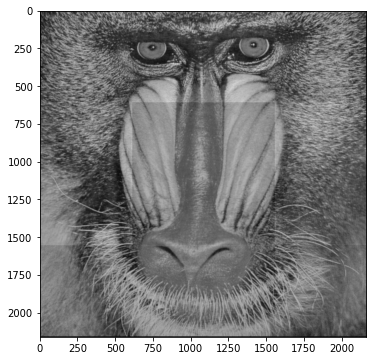

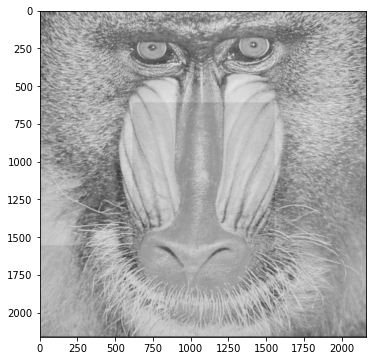

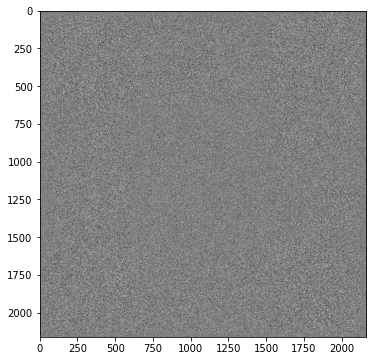

In [4]:
# phase: なんでもあり(定義域がない)の値, phase_exp: 複素振幅の形に, np.exp(phase)
phase_exp = tf.dtypes.complex(tf.math.cos(phase), tf.math.sin(phase))


# Input Complex Amplitude: SLMに光があたった状態（light_img: amplitude, A exp(iφ), exp(iφ): phase_exp）
init_plane = tf.math.multiply(light_img, phase_exp)

# Propagation from SLM to Image Plane with normalization
init_plane_add = tf_CGH.add_zero_padding(init_plane)
N = init_plane_add.shape[0]
prop = tf_CGH.band_limited_angular_spectrum(init_plane_add, k, N, l_ambda, z, p)
#     prop = tf_CGH.angular_spectrum(init_plane_add, k, N, l_ambda, z, p)
#     prop = tf_CGH.normalize_amp_one(prop)
prop_rm = tf_CGH.remove_zero_padding(prop)
N = prop_rm.shape[0]

'''
# 1. prop_rmをレンズで変換します

# 2. レンズで変換した直後の面から，再度伝播します

# 3. 伝播結果を比較します
'''

### 収差あり(P_xy:一般化瞳関数)/なし(p_xy: 瞳関数)レンズ変換

u_minus = prop_rm
u_minus = tf_CGH.add_zero_padding(u_minus)
#u_minus = tf_CGH.add_zero_padding(u_minus)

lens = tf_CGH.response_h(o_lens_N, l_ambda, -1.0*lens_f, p)
print(u_minus.shape, lens.shape, P_xy.shape)
u_plus = u_minus * lens * P_xy
#u_plus = u_minus * lens * p_xy

#u_plus = tf_CGH.remove_zero_padding(u_plus)
u_plus = tf_CGH.remove_zero_padding(u_plus)
    ###レンズからimageplaneまで伝搬計算
u_plus_add = tf_CGH.add_zero_padding(u_plus)
N = init_plane_add.shape[0]
image_plane = tf_CGH.band_limited_angular_spectrum(u_plus_add, k, N, l_ambda, z, p)
image_plane_rm = tf_CGH.remove_zero_padding(image_plane)
N = image_plane_rm.shape[0]

imgs = [
    CGH.amp_abs(CGH.intensity(image_plane_rm.numpy())),
    CGH.amp_abs(CGH.amplitude(image_plane_rm.numpy())),
    CGH.phase_norm(CGH.phase(image_plane_rm.numpy())),
]
ImageProcess.show_imgs(imgs)
